# Assignment 7

In [237]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram
from pybaseball import pitching_stats
from sklearn.cluster import AgglomerativeClustering
from tabulate import tabulate
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LogisticRegression

# Part 1
## Data: http://archive.ics.uci.edu/ml/datasets/Heart+failure+clinical+records

### Data Import and Clean

In [25]:
df = pd.read_csv('heart_failure.csv')
# Drop true class labels; won't need for clustering
X = df.drop(columns = ['DEATH_EVENT', 'time'])
X.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0


In [26]:
X.shape

(299, 11)

#### Dummify categorical variables

In [27]:
X = pd.get_dummies(X, columns = ['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking'])
X.head()

,age,creatinine_phosphokinase,ejection_fraction,platelets,serum_creatinine,serum_sodium,anaemia_0,anaemia_1,diabetes_0,diabetes_1,high_blood_pressure_0,high_blood_pressure_1,sex_0,sex_1,smoking_0,smoking_1
0,75.0,582,20,265000.00,1.9,130,1,0,1,0,0,1,0,1,1,0
1,55.0,7861,38,263358.03,1.1,136,1,0,1,0,1,0,0,1,1,0
2,65.0,146,20,162000.00,1.3,129,1,0,1,0,1,0,0,1,0,1
3,50.0,111,20,210000.00,1.9,137,0,1,1,0,1,0,0,1,1,0
4,65.0,160,20,327000.00,2.7,116,0,1,0,1,1,0,1,0,1,0


### Scale
Scale the numeric, non-categorical variables

In [28]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X[['age', 'creatinine_phosphokinase', 'ejection_fraction',
                                   'platelets', 'serum_creatinine', 'serum_sodium']])
X[['age', 'creatinine_phosphokinase', 'ejection_fraction',
                                   'platelets', 'serum_creatinine', 'serum_sodium']] = X_scaled

In [29]:
X.head()

,age,creatinine_phosphokinase,ejection_fraction,platelets,serum_creatinine,serum_sodium,anaemia_0,anaemia_1,diabetes_0,diabetes_1,high_blood_pressure_0,high_blood_pressure_1,sex_0,sex_1,smoking_0,smoking_1
0,0.636364,0.071319,0.090909,0.290823,0.157303,0.485714,1,0,1,0,0,1,0,1,1,0
1,0.272727,1.000000,0.363636,0.288833,0.067416,0.657143,1,0,1,0,1,0,0,1,1,0
2,0.454545,0.015693,0.090909,0.165960,0.089888,0.457143,1,0,1,0,1,0,0,1,0,1
3,0.181818,0.011227,0.090909,0.224148,0.157303,0.685714,0,1,1,0,1,0,0,1,1,0
4,0.454545,0.017479,0.090909,0.365984,0.247191,0.085714,0,1,0,1,1,0,1,0,1,0


### PCA
We can reduce the data down to 5 Principle Components and account for 95~% of the variance in the data. However, I don't think this dataset needs much dimensionality reduction. Additionally, I'd like to interpret the effects of each variable easier.

<IPython.core.display.Javascript object>


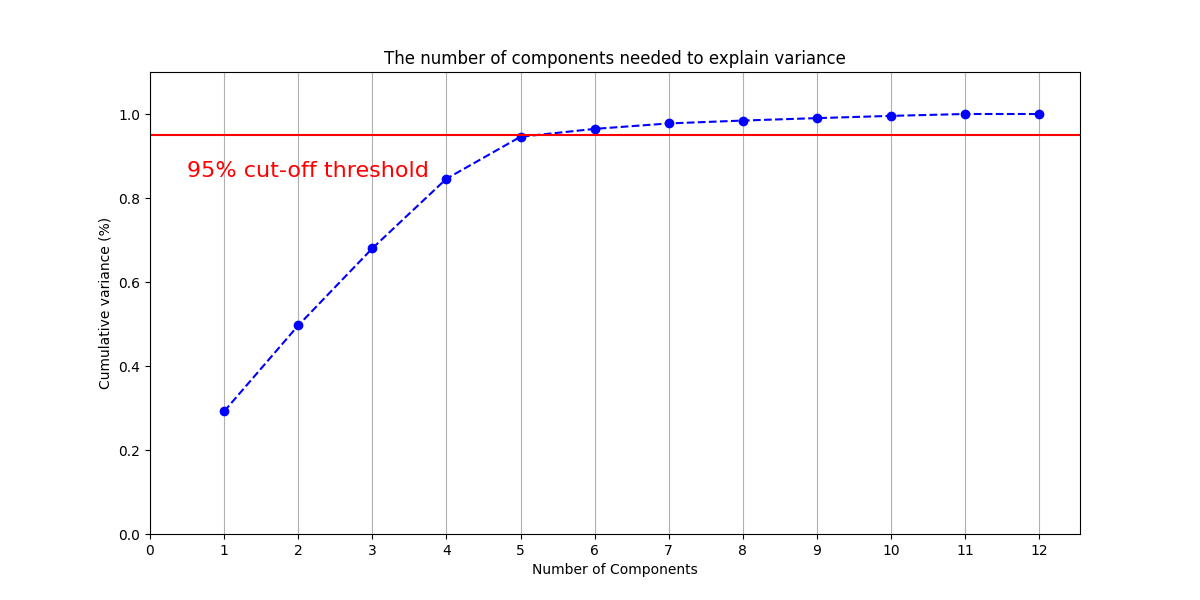

In [35]:
pca = PCA(n_components=12).fit(X)
X_2 = pca.transform(X)
plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi = np.arange(1, 13, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 13, step=1))
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

### Agglomerative Clustering, Dendrogram
Because the output of the original dataset is binary, it would be intuitive to only look to cluster the data into 2 groups. However, it looks like there are some very clear, noticable differences among the patients observed in the dataset and their various health metrics.

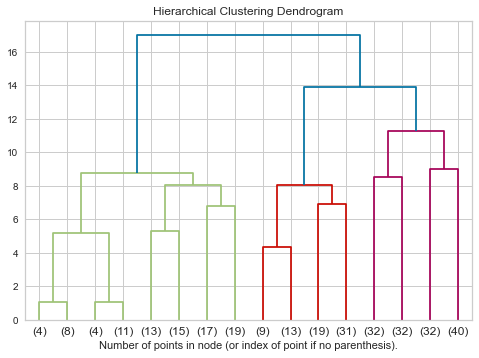

In [44]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)




# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(X)
plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode='level', p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

### KMeans

In [32]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(X)
k_predict = kmeans.predict(X)
df['cluster_class'] = k_predict

#### Visualizing clusters

<IPython.core.display.Javascript object>


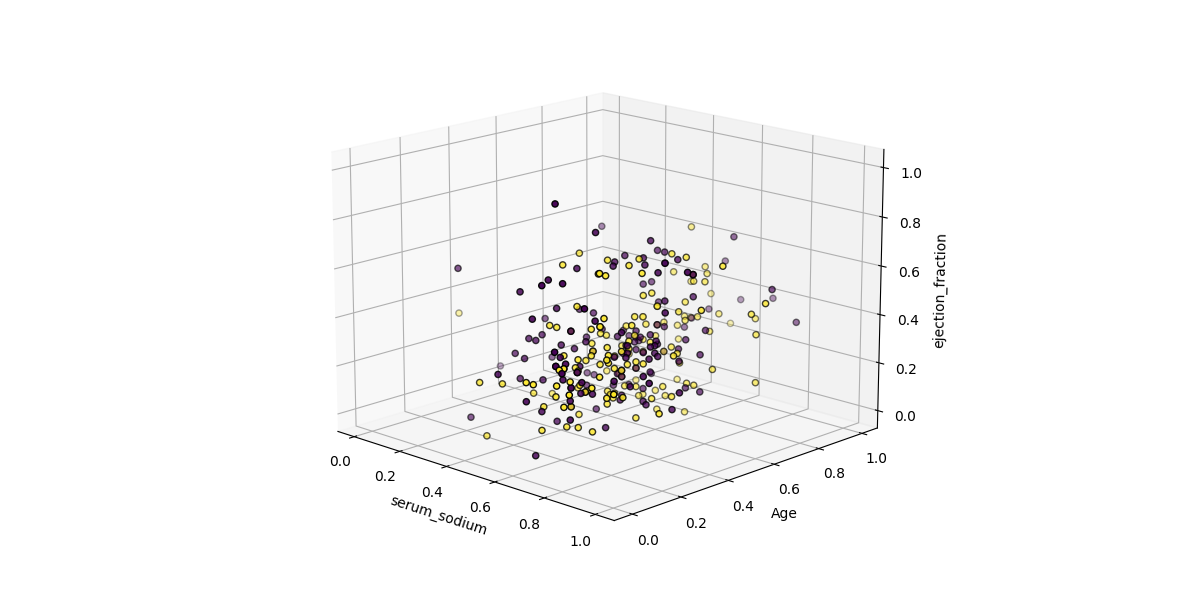

<ipython-input-34-7e2ac7819914>:4: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax1 = Axes3D(fig1, title = "Predicted Species Clusters, with Centroids Marked")


In [34]:
# %matplotlib notebook - Uncomment this to rotate the 3d plot
fig1 = plt.figure()
ax1 = Axes3D(fig1, title = "Predicted Species Clusters, with Centroids Marked")
ax1.scatter3D(X['serum_sodium'], X['age'], X['ejection_fraction'], c=df['cluster_class'], edgecolor='k')
ax1.set_xlabel("serum_sodium")
ax1.set_ylabel("Age")
ax1.set_zlabel("ejection_fraction")
plt.show()

#### Tuning K
I found this neat package, so I figured I'd use it instead of a for-loop.

Unfortunately, it doesn't look like there's a good, intuitive K to pick from here. At this point, I wouldn't consider this dataset very suitable for clustering and presenting a simple problem. The dendrogram paints the same story: the data shows *many* clusters exist within the data. Who knew? Apparently humans have a wide range of health profiles! If we thought of health as a spectrum in terms of risk, we could use a large k to indicate varying levels of health risk, but I'm not convinced this dataset provides a holistic enough health profile to draw any such conclusions.

For the sake of simplifying the question, I'll stick with 2 clusters. What constitutes a healthy individual and a deathly unhealthy individual? We'll use clustering and logistic regression to answer that question.

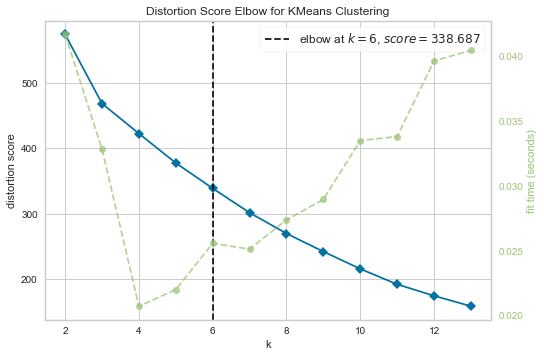

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [61]:
from yellowbrick.cluster import KElbowVisualizer


model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,14))

visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

#### Add the predicted clusters to the (scaled, cleaned) dataset:

In [63]:
X['Cluster'] = k_predict

## Logistic Regression On Clusters

In [70]:
from sklearn import metrics

In [87]:
X_input = X.drop(columns = 'Cluster')
y = X.Cluster

lr = LogisticRegression()
lr.fit(X_input, y)
lr_predictions = lr.predict(X_input)

Logistic Regression 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       145
           1       1.00      1.00      1.00       154

    accuracy                           1.00       299
   macro avg       1.00      1.00      1.00       299
weighted avg       1.00      1.00      1.00       299
 

Confusion Matrix 
 [[145   0]
 [  0 154]] 

ROC-AUC Score 
 1.0 



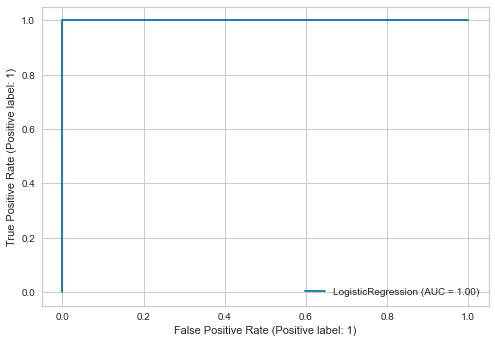

In [88]:
print("Logistic Regression", '\n', metrics.classification_report(y, lr_predictions), '\n')
print("Confusion Matrix", '\n', metrics.confusion_matrix(y, lr_predictions), '\n')
print("ROC-AUC Score", '\n', metrics.roc_auc_score(y, lr_predictions), '\n')
metrics.plot_roc_curve(lr, X_input, X.Cluster)

### Tuning?
I realize it's a copout to say "Welp, no point in tuning", but I didn't expect the clusters to be *that* predictable.
**I would not consider clustering appropriate for classifying individuals in this dataset**. Consider that the true class labels of the original dataset aren't easily predictable for an (untuned) logistic regression model. See below, where I use the data to predict whether or not a patient passed away due to heart failure. We can see that the F1 score and Recall aren't stellar, though in a matter of life and death, I would definitely tune the model to maximize recall.

In [100]:
X_input = X
y = df.DEATH_EVENT
lr = LogisticRegression()
lr.fit(X_input, y)
lr_predictions = lr.predict(X_input)

Logistic Regression 
               precision    recall  f1-score   support

           0       0.74      0.96      0.83       203
           1       0.76      0.29      0.42        96

    accuracy                           0.74       299
   macro avg       0.75      0.62      0.63       299
weighted avg       0.75      0.74      0.70       299
 

Confusion Matrix 
 [[194   9]
 [ 68  28]] 

ROC-AUC Score 
 0.6236658456486043 



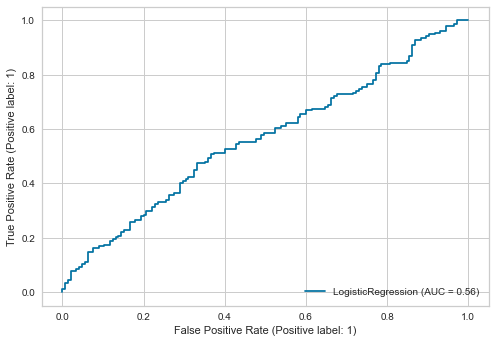

In [101]:
print("Logistic Regression", '\n', metrics.classification_report(y, lr_predictions), '\n')
print("Confusion Matrix", '\n', metrics.confusion_matrix(y, lr_predictions), '\n')
print("ROC-AUC Score", '\n', metrics.roc_auc_score(y, lr_predictions), '\n')
metrics.plot_roc_curve(lr, X_input, X.Cluster)

### Interpreting the Clusters
So, surely there was *some* reason the data clustered. Let's have a look at the input variables and how they relate to the clusters and see if there are any obvious differences. Let's look at the feature importance first (idea and code courtesy of machinelearningmastery):

Feature: 0, Score: 1.89385
Feature: 1, Score: 0.88542
Feature: 2, Score: -2.39101
Feature: 3, Score: -0.26533
Feature: 4, Score: 2.26051
Feature: 5, Score: -1.19900
Feature: 6, Score: -0.13746
Feature: 7, Score: 0.13746
Feature: 8, Score: -0.15773
Feature: 9, Score: 0.15773
Feature: 10, Score: -0.14689
Feature: 11, Score: 0.14690
Feature: 12, Score: 0.27164
Feature: 13, Score: -0.27164
Feature: 14, Score: 0.11451
Feature: 15, Score: -0.11451
Feature: 16, Score: 0.68042


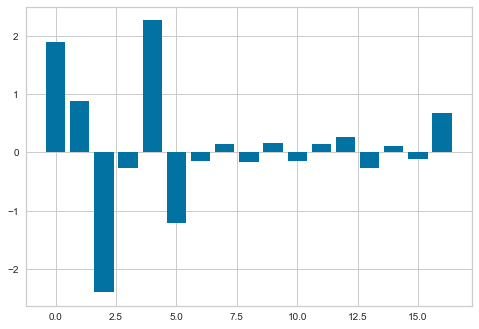

In [160]:
importance = lr.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

Interestingly, the features with the highest coefficients are the following:

In [163]:
X.columns[2], X.columns[4]

('ejection_fraction', 'serum_creatinine')

This of importance because the paper that was written using this data is titled:
>"Machine learning can predict survival of patients with heart failure from serum creatinine and ejection fraction alone".
(Davide Chicco, Giuseppe Jurman, 2020)

So, very interesting that our clustering is *also* predictable using these two features. **This does not mean that our clustering assignment is a suitable replacement for the "DEATH_EVENT" class labels**. With the help of the Rand Index, which measures *similarity* between two classifications, we can see that the true class labels and our clusterings are almost nothing alike (values close to 1 represent 100% similarity):

In [165]:
metrics.rand_score(df.DEATH_EVENT, df.cluster_class)

0.4990011447554488

## Part 2: Logistic Regression 2, Electric Bugaloo

In [167]:
from pybaseball import statcast_pitcher

In [188]:
kershaw_stats = statcast_pitcher('2015-06-01', '2015-10-01', 477132)

Gathering Player Data


Now, something a lot less grim. Predicting strikeouts! This dataset is from Clayton Kershaw's 2015 season, when MLB first started using Statcast to track pitch data. For the sake of simplicity, I will narrow down the dataset to only include 2-strike counts, and pitches that resulted in an event, which can take on the following classes:

In [178]:
kershaw_stats.events.unique()

array(['strikeout', nan, 'field_out', 'single', 'field_error',
       'grounded_into_double_play', 'fielders_choice', 'walk', 'double',
       'hit_by_pitch', 'force_out', 'sac_fly', 'triple', 'home_run',
       'sac_bunt', 'double_play', 'fielders_choice_out',
       'pickoff_caught_stealing_3b'], dtype=object)

Pitching for a strikeout is generally considered the best outcome, though any event that results in an out is desirable. Again, for the sake of simplicity, I will dumb down these classes into either "Strikeout" or "Not A Strikeout" to look at what makes a Kershaw-induced strikeout special. These will be the binary classes that we will attempt to classify. If you would like full documentation on what these variables mean, refer to:
https://baseballsavant.mlb.com/csv-docs

### Cleaning
Filter to 2 strike counts resulting in an event:

In [194]:
kershaw_stats = kershaw_stats[(kershaw_stats['strikes'] == 2) & (kershaw_stats['events'].notnull())]

I'm going to handwave this part and remove a bunch of columns that don't have anything to do with the qualities of a pitch itself, such as if anyone is on 2nd or 3rd base, or what inning it is (though these may very well be important things for a pitcher's pitch selection!).

In [200]:
kershaw_stats = kershaw_stats[['pitch_type', 'release_speed','release_pos_x', 'release_pos_z', 'release_pos_y',
               'effective_speed', 'release_spin_rate', 'spin_axis', 'plate_x', 'plate_z', 'events']]

Now, I will turn "events" into a binary class: strikeout (1) or not (0):

In [201]:
kershaw_stats['events'] = kershaw_stats['events'].apply(lambda x: 1 if x == 'strikeout' else 0)

<ipython-input-201-b54f7126a749>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kershaw_stats['events'] = kershaw_stats['events'].apply(lambda x: 1 if x == 'strikeout' else 0)


Making the only categorical input variable (pitch_type) dummified. Kershaw is a 3 strike pitcher (Curveball, Fastball, Slider), so the result is turning one input into three. I will also separate the input (X) from the output (y):

In [247]:
X = pd.get_dummies(kershaw_stats, columns = ['pitch_type']).drop(columns = 'events')
y = kershaw_stats.events

Scale:

In [248]:
stand_scaler = StandardScaler()
X[['release_speed','release_pos_x','release_pos_z','release_pos_y',
   'effective_speed','release_spin_rate','spin_axis',
   'plate_x','plate_z']] = stand_scaler.fit_transform(
            X.drop(columns = ['pitch_type_CU', 'pitch_type_FF', 'pitch_type_SL']))

Finally, split into training and test data:

In [249]:
from sklearn.model_selection import train_test_split

In [250]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = .3)

### Cleaned Dataset
Finally, we have clean data!

In [251]:
X_train.head()

,release_speed,release_pos_x,release_pos_z,release_pos_y,effective_speed,release_spin_rate,spin_axis,plate_x,plate_z,pitch_type_CU,pitch_type_FF,pitch_type_SL
885,0.781867,-0.573756,1.369580,-1.953260,0.859012,-0.248009,-0.362190,-0.283987,-0.316823,0,1,0
583,-2.166062,-1.216691,0.666409,1.441172,-2.166496,-1.140177,1.992822,0.511507,0.124761,1,0,0
48,0.641489,-0.252289,-1.041292,-0.660143,0.652392,0.498498,-0.441751,-0.791749,0.612827,0,1,0
422,0.781867,-0.941148,-0.739933,-1.145062,0.903288,-0.147868,-0.807732,-0.673271,0.473380,0,1,0
840,0.313941,-0.527832,0.565956,0.350104,0.253910,1.081138,-0.139418,-1.045630,-1.664815,0,0,1


## Logistic Regression Using statsmodels

In [252]:
import statsmodels.api as sm

In [283]:
logit = sm.Logit(y_train,sm.add_constant(X_train))
res = logit.fit()
print(res.summary())

Optimization terminated successfully.
         Current function value: 0.641287
         Iterations 12
                           Logit Regression Results                           
Dep. Variable:                 events   No. Observations:                  164
Model:                          Logit   Df Residuals:                      152
Method:                           MLE   Df Model:                           11
Date:                Thu, 19 Aug 2021   Pseudo R-squ.:                 0.06025
Time:                        01:08:05   Log-Likelihood:                -105.17
converged:                       True   LL-Null:                       -111.91
Covariance Type:            nonrobust   LLR p-value:                    0.2628
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.2982   6.79e+06  -4.39e-08      1.000   -1.33e+07    1.33e+07
release

In [313]:
preds = np.where(res.predict(sm.add_constant(X_test)) < .5, 0, 1)

In [322]:
print("Logistic Regression", '\n', metrics.classification_report(y_test, preds), '\n')
print("Confusion Matrix", '\n', metrics.confusion_matrix(y_test, preds), '\n')
print("ROC-AUC Score", '\n', metrics.roc_auc_score(y_test, preds), '\n')

Logistic Regression 
               precision    recall  f1-score   support

           0       0.57      0.79      0.67        39
           1       0.53      0.28      0.37        32

    accuracy                           0.56        71
   macro avg       0.55      0.54      0.52        71
weighted avg       0.55      0.56      0.53        71
 

Confusion Matrix 
 [[31  8]
 [23  9]] 

ROC-AUC Score 
 0.5380608974358975 



### Results
Less-than-stellar results. The only significant predictor turned out to be "plate_z", which records the z axis value at which the ball crosses the plate. So, it looks like the lower Kershaw throws, the more likely he is to get a strikeout. The rest of the coefficients have too low p-values to put much stock into, though the runner-up in terms of significant p-values would be "release_spin_rate". By conventional wisdom, higher spinrate is synonymous with a better quality pitch, so it makes sense that the p-value was nearly significant. It's no surprise to Kershaw fans, but his Curveball and Slider look to be his strikeout pitches based on the coefficients.